In [1]:
import numpy as np
from numpy import sin, cos,exp,pi
from time import process_time, time
from scipy.optimize import curve_fit, least_squares
from scipy.fft import fft,fftshift,fft2, fftfreq, ifft
from scipy.signal import oaconvolve, medfilt2d

from scipy.ndimage import rotate
from scipy.interpolate import interp1d

import h5py
from skimage.transform import radon
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import transforms
from PIL import Image, ImageFilter
import joblib as jb
import tifffile as tfl
import os
from IPython.display import clear_output
import re
import pandas as pd

In [2]:
%run "C:\Users\gabri\Documents\Python Scripts\NPGMI-Library\NPGMI Base Code.ipynb"

### 3PGMI PRL Data

In [ ]:
prld, prlcont = np.genfromtxt("PRLPOLYCONTDATA.csv",delimiter=",").T
prlfreq = np.genfromtxt("PRLFREQDATA.csv").T[1]
prlconterr = np.genfromtxt("PRLPOLYCONTERROR.csv",delimiter=",").T[1] - prlcont

### SEM Profile Processing 

In [ ]:


oldbbx,oldbbprofile = np.genfromtxt("oldbbprofile.csv", delimiter= ",")[:-2].T
n_periods = 4
uniquex, uniqueind = np.unique(oldbbx,return_index = True)
oldbbprofile = oldbbprofile[uniqueind]
oldbbsize = np.max(uniquex) - np.min(uniquex)

interpfuncbb = interp1d(uniquex, oldbbprofile)
bbx = np.linspace(np.min(uniquex), np.max(uniquex),1024)

bbprofile = interpfuncbb(bbx)
bbsize = np.max(bbx) - np.min(bbx)



# ftbb = np.abs(fft(exp(1j * phi2[19]/2 * bbprofile)))
# freqsbb = get_freqs(ftbb,bbsize)

# oldftbb = np.abs(fft(exp(1j * phi2[19]/2 * oldbbprofile)))
# oldfreqsbb = get_freqs(oldftbb,oldbbsize)

fig,ax1 = plt.subplots(figsize=(12,8))

# ax1.plot(oldbbprofile,"o-")
ax1.plot(bbprofile)


# ax1.plot(oldfreqsbb,oldftbb)
# ax1.plot(freqsbb,ftbb)
# ax1.set_xlim(-3e7,3e7)

plt.show()

In [ ]:
def smooth_profile(profile, pct_diff):
    for i in range(1,len(profile)-1):
        a,b,c = profile[i-1], profile[i], profile[i+1]
        if b != 0:
            if abs((b - a)/b) > (pct_diff/100.0) and abs((b- c)/b) > (pct_diff/100.0):
                profile[i] = (a+c)/2
    return profile


oldrectangulargx, oldrectangularprofile = np.genfromtxt("oldrectprofile.csv", delimiter = ",")[:-1].T

oldruniquex, oldruniqueind = np.unique(oldrectangulargx,return_index=True)
oldrectangularprofile = oldrectangularprofile[oldruniqueind]


oldrsize = np.max(oldruniquex) - np.min(oldruniquex) 


oldrprofile = smooth_profile(oldrectangularprofile, 50)



fig,ax1 = plt.subplots(figsize=(12,8))
ax1.plot(oldrprofile, "-")



plt.show()
plt.close(fig)

In [ ]:
rx, rprofile = np.genfromtxt("rectprofile.csv", delimiter = ",")[:-1].T
rux, testind = np.unique(rx,return_index=True)
rprofile = smooth_profile(rprofile[testind],10)


rprofile[488:492] = 0.99
rprofile[560:576] = 0.99
rprofile[670:755] = 0.99


interpfuncr = interp1d(np.linspace(rux[0],rux[-1],len(rprofile)),rprofile)

rprofile = interpfuncr(np.linspace(rux[0],rux[-1],1024))

rsize = np.max(rux) - np.min(rux)


fig,ax1 = plt.subplots(figsize=(12,8))
ax1.plot(rprofile,"-")



# ftr = np.abs(fft(exp(1j*phi2[19]/2 * rprofile),norm = "forward"))
# freqsr = get_freqs(ftr,rsize)
# ax1.plot(freqsr,ftr)
# ax1.plot(freqsi, fti,label = "Ideal G(x)")
# plt.xlim(-3e7,3e7)


plt.show()
plt.close(fig)

### Rotation

In [ ]:

t0 = time()
# bbdeg = np.arange(3.9,4.2,0.05)
bbdeg = np.array([4.05])
# rdeg = np.arange(1,5,1)
rdeg = np.array([0])




RotatedBB = RotatedSpectrum(bbdeg,bbprofile,bbsize,h2,p)
RotatedRect = RotatedSpectrum(rdeg,rprofile,rsize,h1,p)

rotbbprofiles = RotatedBB.rotated_profiles
rotrprofiles = RotatedRect.rotated_profiles

print(time() - t0, "seconds")




In [ ]:



fig,ax = plt.subplots(figsize = (12,8))

[ax.plot(rotbbprofiles[i], label = bbdeg[i]) for i,_ in enumerate(bbdeg)]
# ax.plot(rotbbprofiles[0])
# [ax.plot(rotrprofiles[i], label = rdeg[i]) for i,_ in enumerate(rdeg)]

# ax.plot(rotrprofiles[0])
# plt.xlim(0,3000)



ax.legend()
plt.show()


plt.close(fig)

### Simulations

In [5]:

p = 2.4e-6
L = 8.8

lam = np.array([5e-10])
plam = np.array([1])

polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
polyspectrum[0]*=1e-9
lam,plam = polyspectrum.copy()

x0 = np.array([0])



mt = 3


Nbc = 5e28*4.149e-15
h1,h2,h3 = 15.8e-6,29e-6,15.8e-6

phi1,phi2,phi3 = Nbc*lam*h1,Nbc*lam*h2,Nbc*lam*h3
# phi1,phi2,phi3 = np.array([pi/2]),np.array([pi]),np.array([pi/2])
idealgrating_phase_offset = -413*pi/440


camsize = 2.5e-2
slitx = 500e-6
slity = 100e-6

xbin = 1e-6
ybin = 5e-6

res = 150e-6
d1 = np.array([4.6e-2])
L1 = 4.75
d3pgmi = np.linspace(2,7,50)*1e-2


G1sd = {"p":p, "L1": np.array([L1 - d1]), "phi":phi1, "phase_offset": idealgrating_phase_offset}
G1sd["L2"] = d1

G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi":phi2, "phase_offset": idealgrating_phase_offset}

d3pgmi[d3pgmi == d1] = d1 + 5e-5

G2sd["L2"] = d3pgmi
# G2sd["L2"] = np.array([-1.2,-1,-0.8,0.8,1,1.2])*1e-2 + d1

# G2sd["L2"][G2sd["L2"] == G2sd["L1"]] = G2sd["L1"] + 5e-5

G3sd = {"p":p, "L1": G2sd["L2"] + G2sd["L1"], "phi":phi3, "phase_offset": idealgrating_phase_offset}
G3sd["L2"] = np.array([L]) - G3sd["L1"]

simaptsideal = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":RectGrating(G3sd)}

# simaptsideal = {"G1":RectGrating(G1sd),"G2":Sample(G2sd,10*p,grating_equation(np.linspace(0,10*p,1001),p,0)),"G3":RectGrating(G3sd)}


# simaptsrect = {"G1":GratingFromImage(G1sd, rsize, rprofile),\
#                       "G2":GratingFromImage(G2sd,rsize,rprofile),\
#            "G3":GratingFromImage(G3sd,rsize, rprofile)}



# simaptsbb = {"G1":GratingFromImage(G1sd, rsize, rprofile),\
#                       "G2":Sample(G2sd,bbsize,np.array(rotbbprofiles)),\
#            "G3":GratingFromImage(G3sd,rsize, rprofile)}







siminit = {"lam":lam, "plam":plam, "L":L,"d":d3pgmi - d1,"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin ,"pos":np.array([[0],[1]]),\
           "camsize" : camsize ,"convmode" : "valid", "slitx": slitx,"slity" : slity, "res": res, "batches" : 1000  }

In [4]:

p = 180e-6
L = 1.556

lam = np.array([1550e-9])
plam = np.array([1])

# polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
# polyspectrum[0]*=1e-9
# lam,plam = polyspectrum.copy()

x0 = np.array([0])



mt = 5


Nbc = 5e28*4.149e-15

phi1,phi2,phi3 = np.array([pi/2]),np.array([pi]),np.array([pi/2])
idealgrating_phase_offset = -413*pi/440


camsize = 25e-2
# slitx = 500e-6
# slity = 100e-6

xbin = 1e-6
ybin = 5e-6

res = 3.75e-6


d12 = np.linspace(37,39,101)*1e-2

d23 = 38e-2
d3c = 38e-2
ds2 = L - d23 - d3c

ds1 = ds2 - d12

d12[d12 == d23] = d23 + 5e-5


G1sd = {"p":p, "L1": np.array([ds1]), "phi":phi1, "phase_offset": idealgrating_phase_offset}
G1sd["L2"] = d12

G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi":phi2, "phase_offset": idealgrating_phase_offset}

G2sd["L2"] = np.array([d23])


G3sd = {"p":p, "L1": G2sd["L2"] + G2sd["L1"], "phi":phi3, "phase_offset": idealgrating_phase_offset}
G3sd["L2"] = np.array([d3c])

simaptsideal = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":RectGrating(G3sd)}

siminit = {"lam":lam, "plam":plam, "L":L,"d":d12-d23,"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin ,"pos":np.array([[0],[1]]),\
           "camsize" : camsize ,"convmode" : "valid", "res": res, "batches" : 5000  }

In [6]:
t0 = time()


simideal = PGMI(simaptsideal,siminit)
simideal.propagate_to("G1")
simideal.propagate_to("G2")
simideal.propagate_to("G3")
simideal.generate_after("G3")



    



print(time() - t0, "seconds")


(1000, 50, 41, 25) after parallel
(50, 41, 25000) after reshape
(50, 25000) before convolution
Finding contrast
417.30152225494385 seconds


(10, 101)

In [7]:
# cont3ideal1 = simideal.contrast
# cont3ideal3 = simideal.contrast
cont = simideal.contrast
# cont3ideal5 = simideal.contrast
# # cont3polyrect5 = simrect.contrast
# cont3monorect5 = simrect.contrast
# # cont3monorect = simrect.contrast

### Plots

In [111]:

for ind in range(simideal.intensity.shape[0]):
    # print(ind)
    fig, ax1 = plt.subplots(figsize  = (12,8))
    clear_output(wait= True)
#     theorycurve = cosine_func(simbb.x, np.mean(I3bb[ind]), np.amax(I3bb[ind]) - np.mean(I3bb[ind]),\
#                                            L*p/simbb.d[ind],0)
    ax1.plot(simideal.x*1e3,simideal.intensity[ind], label = "Sim, $D_{23}$ - $D_{12}$ = %.2f mm" % ((d3pgmi[ind])*1e3))
    ax1.plot(simideal.x*1e3,cosine_func(simideal.x, *simideal.fitparams[ind]), label = "Fit, $D_{23}$ - $D_{12}$ = %.2f mm" % ((d3pgmi[ind])*1e3))
#     ax1.plot(simbb.x, theorycurve, label = "Theory, $D_{23}$ - $D_{12}$ = %.2f mm" % (simbb.d[ind]*1e3) )
#     theorycurves.append(theorycurve)

    ax1.legend(loc = "upper right")
    # ax1.set_xlim(5e-3,10e-3)
    ax1.set_ylim()
    ax1.set_title("C = %.3f%%" % (np.squeeze(simideal.contrast)[ind]*100), fontsize = 35)
    plt.pause(0.5)
#     ax1.cla()
    plt.show()
    plt.close(fig)
    
    

KeyboardInterrupt: 

In [9]:
cont[np.argmax(cont)] = 0

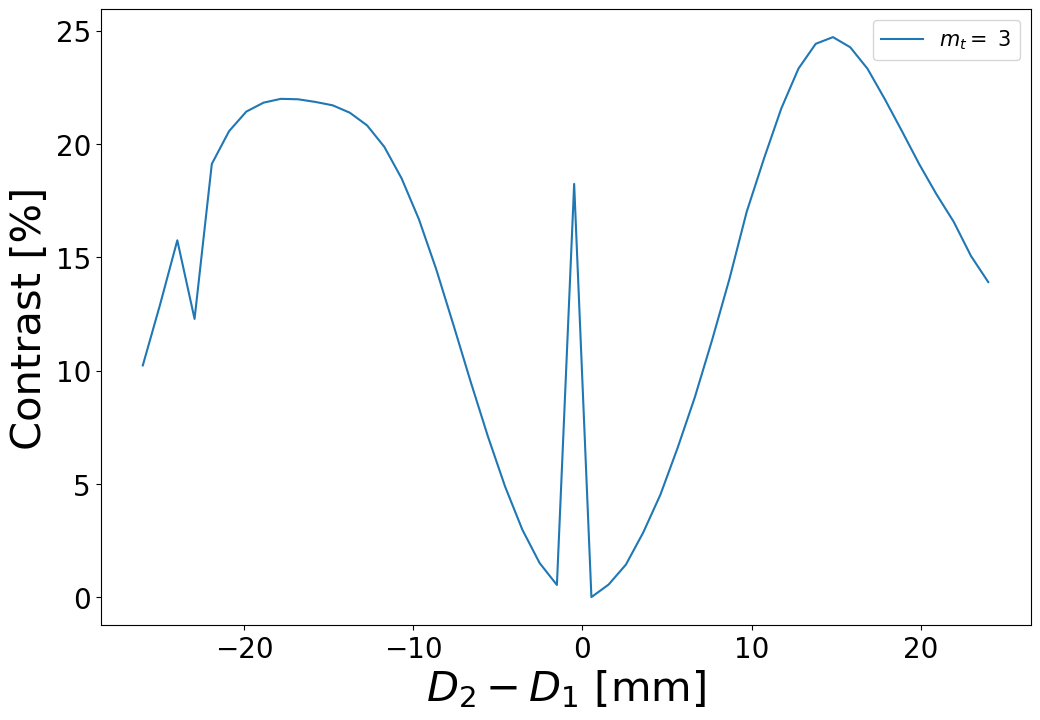

In [10]:
fig, ax1 = plt.subplots(figsize  = (12,8))

# ax1.set_prop_cycle(color = ["blue","red","black"])
# ax1.plot(simideal.d*1e3, cont3ideal1*1e2, label = r"$m_t = 1$")
ax1.plot(simideal.d*1e3, cont*1e2, label = r"$m_t = $ %d"  % mt)
# ax1.plot(simideal.d*1e3, cont3ideal5*1e2, label = r"$m_t = 5$")

# [ax1.plot(simideal.d*1e3, contlam[i]*1e2, label = r"$\lambda$= %.f Å" % (lams[i]*1e10)) for i in range(len(contlam))]
# ax1.set_ylim(0,100)


# ax1.plot(simrect.d[np.argmin(np.abs(simrect.d + 21e-3)):]*1e3, cont3monorect[np.argmin(np.abs(simrect.d + 21e-3)):]*1e2, label = "Mono, m = {-1,1,1}")


# ax1.plot(simrect.d[np.argmin(np.abs(simrect.d + 21e-3)):]*1e3, cont3monorect5[np.argmin(np.abs(simrect.d + 21e-3)):]*1e2, label = "Mono, m = {-5,5,1}")
# ax1.plot(simrect.d[np.argmin(np.abs(simrect.d + 21e-3)):]*1e3, cont3polyrect5[np.argmin(np.abs(simrect.d + 21e-3)):]*1e2, label = "Poly, m = {-5,5,1}")


# ax1.plot(simbb.d[8:-4]*1e3, cont3bb5[8:-4], label = "5 order Bat rotated %.1f degrees" % abs(bbdeg))



# ax1.plot(prld,prlcont, "rx", label = "Data")
# ax1.set_ylim(0,0.04)



# ax2 = ax1.twinx()


# ax2.plot(simrect.d[5:-4]*1e3, freq3monorect[5:-4], label = "All Rectangular Gratings")

# ax2.plot(simrect.d[5:-3]*1e3, freq3monorect5[5:-3], label = "All Rectangular Gratings")


# ax2.plot(simbb.d[5:-3]*1e3, freq3bb[5:-3], "b-",  label = "G2 rotated %.2f degrees" % abs(bbdeg))


# ax2.plot(simrect.d*1e3, abs(1/fitparams3rect5[:,2]) / (1000), "o", label = "All Rectangular Gratings")




# ax2.plot(prld,prlfreq, "bo", label = "Experimental Data")


# ax2.plot(simbb.d*1e3, abs(simbb.d / (L*p*1e3)), label = r"$\frac{d}{Lp}$")

# ax1.legend(loc = (0.3185,0.8), fontsize = 15)

ax1.legend(fontsize = 15)

# ax2.legend(loc = "upper left", fontsize = 20)

ax1.set_xlabel(r"$D_2 - D_1$ [mm]", fontsize = 30)
ax1.set_ylabel("Contrast [%]", fontsize = 30)
# ax2.set_ylabel(r"Frequency $[mm^{-1}]$", fontsize = 30)
# ax1.set_title("Contrast vs. G2-G3 Separation, %d diffraction order%s" % (mt, "s" if mt > 1 else ""))
ax1.tick_params(labelsize = 20)
# ax2.tick_params(labelsize = 20)


# fig.savefig("3PGMI_double_peaks_lam.png")

plt.show()
plt.close(fig)